# Tutorial 2: Data pre-processing for STARmap_PLUS data

STARmap PLUS enables high-resolution spatial transcriptomics along with protein detection in the same tissue section. The pre-processings aim to regist the extracellular proteins with cells. 

In [21]:
import os
import scanpy as sc 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

### Define the path and hyperparameters

In [22]:
N = 3                   # retrieved number of cells
threshold_tau = 15      # threshold distance
threshold_plaque = 50   # threshold distance

In [ ]:
# please change the path according to your data location

name = '13months-disease-replicate_1_random.h5ad'
path = os.path.join('/home/wzk/ST_data/AD_mouse', name)
save_dir = '/home/wzk/ST_data/AD_mouse/'

rna_adata = sc.read_h5ad(path)
path_plaque = '/home/wzk/ST_data/AD_mouse/tau&abeta/plaque_13months-disease-replicate_1.csv'
tau_file = np.load('/home/wzk/ST_data/AD_mouse/tau&abeta/13months-disease-replicate_1_tau_center.npy')

plaque_file = pd.read_csv(path_plaque)

### Plot RNA and MSI data in the original coodinates

/home/wzk/anaconda3/envs/pytorch_zk/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


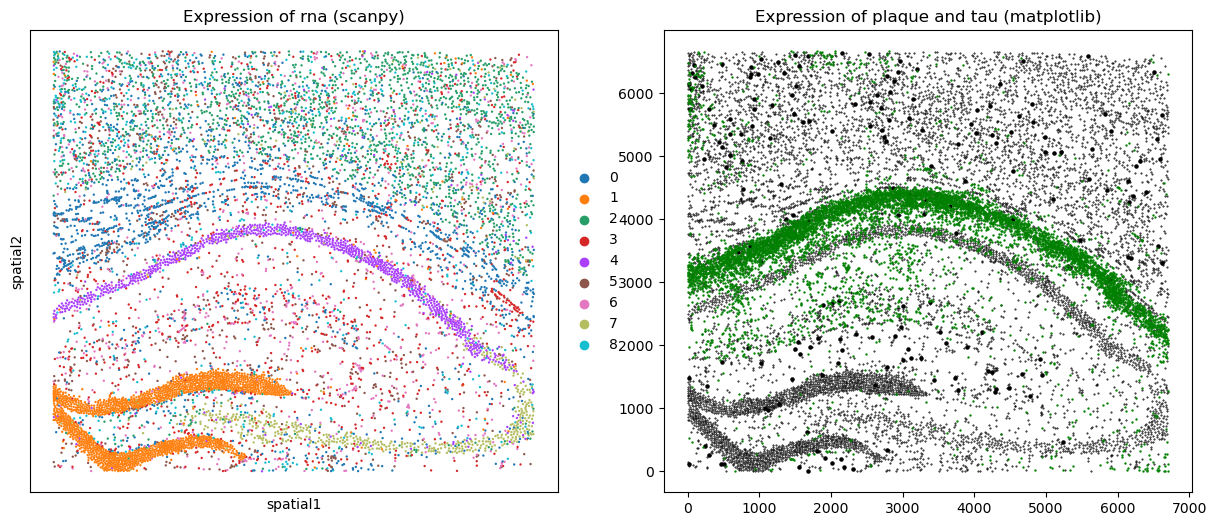

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.embedding(rna_adata, basis='spatial', color='leiden', title=f'Expression of rna (scanpy)', ax=axs[0], show=False)

axs[1].set_title('Expression of plaque and tau (matplotlib)')
axs[1].scatter(plaque_file['m.cx'].values, plaque_file['m.cy'].values, color='black', s=5) 
axs[1].scatter(rna_adata.obsm['spatial'][:, 0], rna_adata.obsm['spatial'][:, 1], color='black', s=0.2, ) 

if name[0] == '8':
    x_max = tau_file[:, 0].max()
    axs[1].scatter(x_max - tau_file[:, 0], tau_file[:, 1], color='green', s=0.5)  
else:
    axs[1].scatter(tau_file[:, 0], tau_file[:, 1], color='green', s=0.5)  

plt.show()

### Calculate the distance matrix

In [25]:
plaque_coordinates = np.array((plaque_file['m.cx'].values, plaque_file['m.cy'].values)).T
tau_coordinates = np.array((tau_file[:, 0], tau_file[:, 1])).T
cell_coordinates = rna_adata.obsm['spatial']

distance_matrix_plaque_cell = np.sqrt(((plaque_coordinates[:, np.newaxis, :] - cell_coordinates[np.newaxis, :, :]) ** 2).sum(axis=2))
distance_matrix_tau_cell = np.sqrt(((tau_coordinates[:, np.newaxis, :] - cell_coordinates[np.newaxis, :, :]) ** 2).sum(axis=2))

In [26]:
temp_tau = np.argsort(distance_matrix_tau_cell, axis=1)[:, :N]
temp_plaque = np.argsort(distance_matrix_plaque_cell, axis=1)[:, :N]

### Align proteins to cells according to the predefined distances

In [27]:
mask_tau = (distance_matrix_tau_cell.min(axis=1) < threshold_tau)
mask_plaque = (distance_matrix_plaque_cell.min(axis=1) < threshold_plaque)

temp_tau = temp_tau[mask_tau, ].reshape(-1)
temp_plaque = temp_plaque[mask_plaque, ].reshape(-1)

In [28]:
index_tau = np.zeros(rna_adata.shape[0])
for i in temp_tau.tolist():
    index_tau[i] = 1
print(index_tau.sum())

index_plaque = np.zeros(rna_adata.shape[0])
for i in temp_plaque.tolist():
    index_plaque[i] = 1
print(index_plaque.sum())

1116.0
429.0


In [29]:
rna_adata.obs['tau'] = index_tau
rna_adata.obs['plaque'] = index_plaque

### Visualize the aligned data

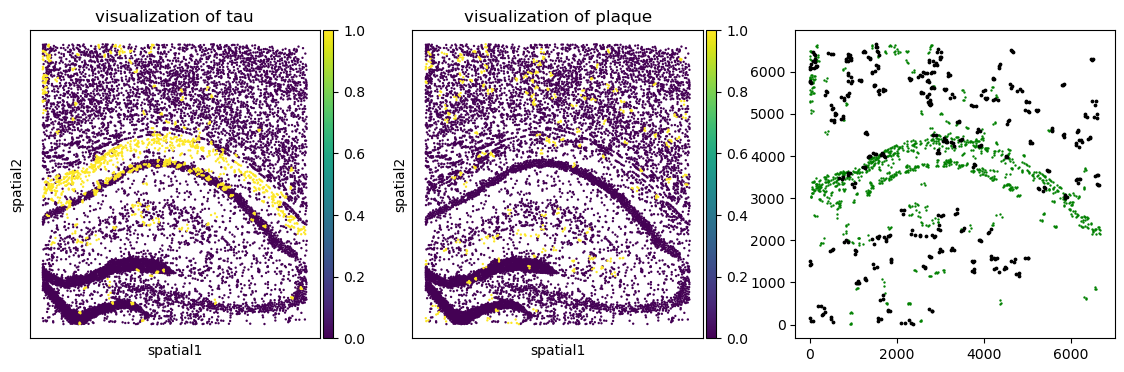

In [37]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

sc.pl.embedding(rna_adata, basis='spatial', color='tau', title='visualization of tau', ax=axs[0], show=False)
sc.pl.embedding(rna_adata, basis='spatial', color='plaque', title=f'visualization of plaque', ax=axs[1], show=False)

mask_tau = rna_adata.obs['tau'].values == 1
mask_plaque = rna_adata.obs['plaque'].values == 1
axs[2].scatter(rna_adata.obsm['spatial'][mask_tau, 0], rna_adata.obsm['spatial'][mask_tau, 1], color='green', s=0.5)  
axs[2].scatter(rna_adata.obsm['spatial'][mask_plaque, 0], rna_adata.obsm['spatial'][mask_plaque, 1], color='black', s=3)  